# AI-Generated Text Detection - Fine-tune BERT

In [ ]:

# Run preprocessing script to ensure dataset is ready
# !python3 ../scripts/data_preprocessing.py


Processed dataset saved to ../data/processed_hc3.csv with 85431 valid samples.


## Train BERT Model

In [ ]:
# import fileinput

# for line in fileinput.input('../scripts/train_bert.py', inplace=True, backup='.bak'):
#     print(line.replace('evaluation_strategy=', 'eval_strategy='), end='')

# # Re-invoke your script in the same environment
# import sys
# !{sys.executable} ../scripts/train_bert.py

Transformers version: 4.53.2
Training on a subset of 17086 samples for faster execution.
Training on device: mps
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                  | 0/3420 [00:00<?, ?it/s]/Users/ethanc/Library/Python/3.10/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
{'loss': 0.6082, 'grad_norm': 2.7555558681488037, 'learning_rate': 1.47e-05, 'epoch': 0.06}
{'loss': 0.2464, 'grad_norm': 1.7149401903152466, 'learning_rate': 2.97e-05, 'epoch': 0.12}
{'loss': 0.1504, 'grad_norm'

## Load and Evaluate BERT Model

In [19]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load the fine-tuned model and tokenizer
model_dir = '../models/bert_model'
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)
model = DistilBertForSequenceClassification.from_pretrained(model_dir)

# Example evaluation on a sample text
sample_text = "This is an example sentence to check if the model thinks it is AI or human."
inputs = tokenizer(sample_text, return_tensors='pt', truncation=True, padding=True, max_length=128)
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
print(f"Sample text prediction: {'AI-generated' if prediction == 1 else 'Human-written'}")


Sample text prediction: Human-written


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11680
           1       0.99      0.99      0.99      5407

    accuracy                           1.00     17087
   macro avg       0.99      0.99      0.99     17087
weighted avg       1.00      1.00      1.00     17087



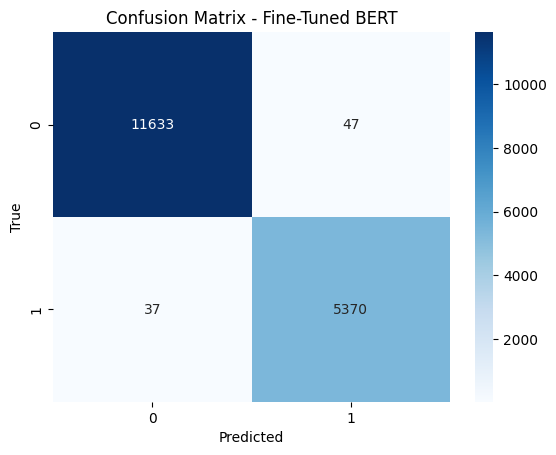

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare test set from the processed CSV
import pandas as pd
test_df = pd.read_csv("../data/processed_hc3.csv")
test_df = test_df.dropna(subset=['text'])
test_df = test_df[test_df['text'].str.strip() != ""]

# Use the last 20% as test set (matching train/val split in train_bert.py)
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(
    test_df['text'], test_df['label'], test_size=0.2, random_state=42
)
test_texts = X_test.tolist()
test_labels = y_test.tolist()

# Get predictions from the fine-tuned model
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

model_dir = '../models/bert_model'
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
model.eval()

predictions = []
pred_probs = []

with torch.no_grad():
    for text in test_texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        predictions.append(pred_label)
        pred_probs.append(probs[0,1].item())  # Probability of class 1 (AI-generated)

y_true = np.array(test_labels)
y_pred = np.array(predictions)
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Fine-Tuned BERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

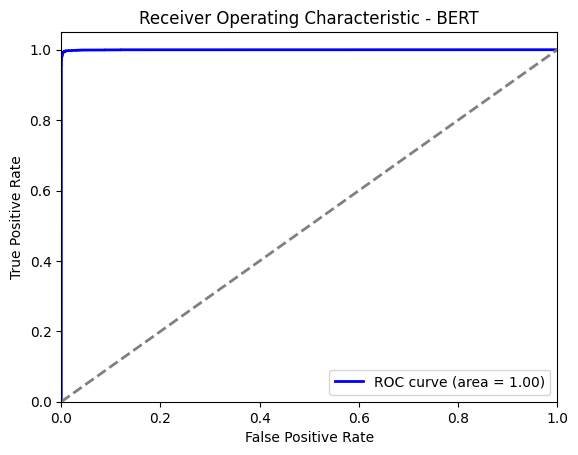

In [21]:
y_pred_prob = np.array(pred_probs)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - BERT')
plt.legend(loc="lower right")
plt.show()

In [22]:
for i in range(5):
    print(f"Text: {test_texts[i][:200]}...")
    print(f"True Label: {y_true[i]}, Predicted: {y_pred[i]}, Probability: {y_pred_prob[i]:.4f}\n")

Text: It's important to be quiet during someone's backswing in golf because the backswing is a crucial part of the golf swing. It's the movement that sets up the rest of the swing and determines the power a...
True Label: 1, Predicted: 1, Probability: 0.9985

Text: There are many possible causes of pain and numbness in the legs. Some possible causes include:

Pinched nerves: This can occur when a nerve becomes compressed or squeezed, often due to pressure from s...
True Label: 1, Predicted: 1, Probability: 0.9896

Text: Big cables that go across the ocean and connect countries to each other . An example of a few of them . [ CANTAT-3 ] ( URL_4 ) - Connects Canada / Iceland / Faroe Islands and Europe - Is really really...
True Label: 0, Predicted: 0, Probability: 0.0003

Text: Not totally related ; but in a way honey does " Spoi " . It ends up killing bacteria on the surface , not letting them grow but collecting dead ones . This is why you should nt give babies honey , as ...
True Label

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer
import torch

# Reload dataset and recreate X_val, y_val
data_path = '../data/processed_hc3.csv'
df = pd.read_csv(data_path)
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != ""]

# Use the same split as training
_, X_val, _, y_val = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Load your saved model and tokenizer
model_dir = '../models/bert_model'
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)

# Recreate val_dataset
val_dataset = TextDataset(X_val.tolist(), y_val.tolist(), tokenizer)

# Create a Trainer object for evaluation
trainer = Trainer(model=model)
print("Trainer and val_dataset are ready for evaluation.")


Trainer and val_dataset are ready for evaluation.


/Users/ethanc/Library/Python/3.10/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


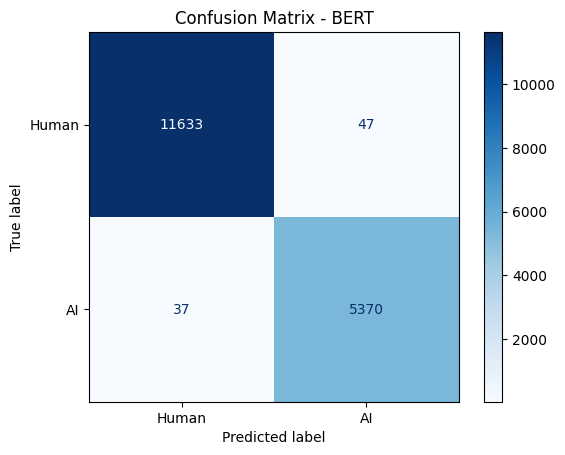

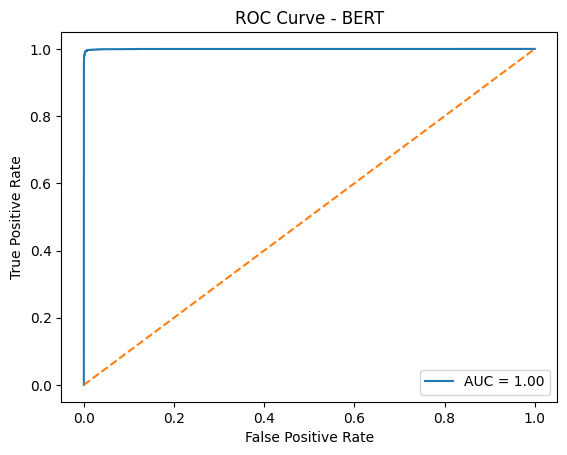

In [34]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Load the saved DistilBERT model and tokenizer
model_dir = '../models/bert_model'
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)

# Recreate validation dataset (make sure X_val, y_val are defined)
val_dataset = TextDataset(X_val.tolist(), y_val.tolist(), tokenizer)

# Create a Trainer object for evaluation
trainer = Trainer(model=model)

def evaluate_model(trainer, val_dataset):
    preds_output = trainer.predict(val_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels = preds_output.label_ids

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'AI'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - BERT")
    plt.show()

    # ROC Curve
    probs = torch.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("ROC Curve - BERT")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Run evaluation
evaluate_model(trainer, val_dataset)
